## Unsupervised Learning Capstone:

For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time

import nltk
from nltk.corpus import reuters, stopwords
import spacy
import re
%matplotlib inline

In [2]:
#each file is pre-labeled for train (~73%) and test (remaining 27%)
train_files = list(filter(lambda x: x.startswith('training'), reuters.fileids()))
test_files = list(filter(lambda x: x.startswith('test'), reuters.fileids()))

print(train_files[:3])
print(test_files[:3])
print(len(train_files))
print(len(test_files))

['training/1', 'training/10', 'training/100']
['test/14826', 'test/14828', 'test/14829']
7769
3019


In [3]:
#see what this data looks like
train_raw = reuters.raw(train_files)
test_raw = reuters.raw(test_files)

print(train_raw[:500])

BAHIA COCOA REVIEW
  Showers continued throughout the week in
  the Bahia cocoa zone, alleviating the drought since early
  January and improving prospects for the coming temporao,
  although normal humidity levels have not been restored,
  Comissaria Smith said in its weekly review.
      The dry period means the temporao will be late this year.
      Arrivals for the week ended February 22 were 155,221 bags
  of 60 kilos making a cumulative total for the season of 5.93
  mln against 5.81 at th


In [15]:
#text cleaning function
import string

def text_cleaner(text):
    text = re.sub(r'--',' ', text) #double hyphens cause problems
    text = re.sub('[^A-Za-z0-9]+', ' ', text) #matches characters that are not letters or numbers
    text = re.sub(r'\d+','', text) #this handles digits
    
    #comparison operators format weird
    text = re.sub(r'&lt;', ' ', text)
    text = re.sub(r'&gt;', ' ', text)
    text = re.sub(r'&le;', ' ', text)
    text = re.sub(r'&ge;', ' ', text)
    
    #lowercase and join
    text = text.lower()
    text = ' '.join(text.split())
    return text

In [17]:
train_df = pd.DataFrame()
for file in train_files:
    if len(reuters.categories(file)) == 1:
        train_df = train_df.append({
            'category':''.join(reuters.categories(file)),
            'fileid':file,
            'text':text_cleaner(reuters.raw([file]))}, ignore_index=True)
print('\n{} train files; data shape is {}'.format(len(train_files), train_df.shape))
print('articles eliminated: {}\n'.format(len(train_files) - len(train_df)))
print('dataframe head: \n{}'.format(train_df.head()))

test_df = pd.DataFrame()
for file in test_files:
    if len(reuters.categories(file)) == 1:
        test_df = test_df.append({
            'category':''.join(reuters.categories(file)),
            'fileid':file,
            'text':text_cleaner(reuters.raw(file))}, ignore_index=True)
print('\n{} test files; data shape is {}'.format(len(test_files), test_df.shape))
print('articles eliminated: {}\n'.format(len(test_files) - len(test_df)))
print('dataframe head: \n{}'.format(test_df.head()))


7769 train files; data shape is (6577, 3)
articles eliminated: 1192

dataframe head: 
       category          fileid  \
0         cocoa      training/1   
1           acq     training/10   
2  money-supply    training/100   
3           acq   training/1000   
4          earn  training/10000   

                                                text  
0  bahia cocoa review showers continued throughou...  
1  computer terminal systems lt cpml completes sa...  
2  n z trading bank deposit growth rises slightly...  
3  national amusements again ups viacom lt via bi...  
4  rogers lt rog sees st qtr net up significantly...  

3019 test files; data shape is (2583, 3)
articles eliminated: 436

dataframe head: 
  category      fileid                                               text
0    trade  test/14826  asian exporters fear damage from u s japan rif...
1    grain  test/14828  china daily says vermin eat pct grain stocks a...
2     ship  test/14839  australian foreign ship ban ends but nsw 

In [19]:
#does the test set contain any categories that the train set doesn't?
print(train_df['category'].nunique())
print(test_df['category'].nunique())
print(len(reuters.categories()))

train_cats = train_df['category'].unique()
test_cats = test_df['category'].unique()

print('\n{} cats in test not in train:\n{}'.format(
    len([x for x in test_cats if x not in train_cats]),
    [x for x in test_cats if x not in train_cats]))
print('\n{} cats in train not in test:\n{}'.format(
    len([x for x in train_cats if x not in test_cats]),
    [x for x in train_cats if x not in test_cats]))
#guessing rape-oil and rapeseed are typos?
print('\n{} cats not in train or test:\n{}'.format(
    len(list(set(reuters.categories()) - set(train_cats) - set(test_cats))),
    list(set(reuters.categories()) - set(train_cats) - set(test_cats))))

58
59
90

7 cats in test not in train:
['groundnut', 'rice', 'yen', 'hog', 'naphtha', 'propane', 'coconut']

6 cats in train not in test:
['oilseed', 'nzdlr', 'silver', 'dmk', 'l-cattle', 'rand']

25 cats not in train or test:
['rape-oil', 'sun-meal', 'corn', 'sun-oil', 'palladium', 'dfl', 'cotton-oil', 'rye', 'nkr', 'lin-oil', 'coconut-oil', 'soy-meal', 'soy-oil', 'sorghum', 'groundnut-oil', 'palmkernel', 'rapeseed', 'oat', 'wheat', 'soybean', 'sunseed', 'copra-cake', 'barley', 'castor-oil', 'palm-oil']


In [26]:
#drop cats that are exclusive to train/test
train_df = train_df[~train_df['category'].isin([x for x in train_cats if x not in test_cats])]
test_df = test_df[~test_df['category'].isin([x for x in test_cats if x not in train_cats])]

#should print true if above worked
print(train_df['category'].nunique() == test_df['category'].nunique())

True


In [29]:
from sklearn.model_selection import train_test_split

X_train = train_df['text']
y_train = train_df['category']

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=0.25)

X_test = test_df['text']
y_test = test_df['category']

## tf-idf feature generation

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=2,
                             stop_words='english',
                             lowercase=False,
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True)

X_train_tfidf = vectorizer.fit_transform(X_train)
print('number of features: {}'.format(X_train_tfidf.get_shape()[1]))

#extract features & tfidf scores
X_train_tfidf_csr = X_train_tfidf.tocsr()
n = X_train_tfidf_csr.shape[0]
tfidf_dicts = [{} for _ in range(0,n)]
terms = vectorizer.get_feature_names()

for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_dicts[i][terms[j]] = X_train_tfidf_csr[i,j]
    
#since log base 2 of 1 = 0, tf-idf of 0 means word was present once
#print('original sentence:', X_train[3])
#print('tf_idf vector:', tfidf_dicts[3])

number of features: 10063


## Clustering

idea: use clustering to group categories, then use the best of these groupings for classification?

In [36]:
from sklearn.preprocessing import normalize, Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

X_train_norm = normalize(X_train_tfidf)
X_train_svd = TruncatedSVD(2).fit_transform(X_train_norm)

### k-means

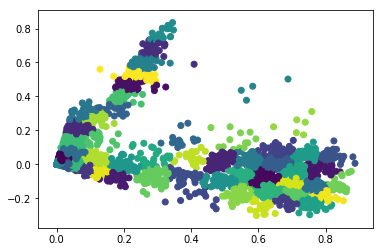

adj rand score: -0.020541502144215545


In [45]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

kmeans = KMeans(n_clusters=52, init='k-means++', n_init=10)
y_pred = kmeans.fit_predict(X_train_svd)

plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_pred)
plt.show()

print('adj rand score: {}'.format(adjusted_rand_score(y_train, y_pred)))

### MiniBatchKMeans

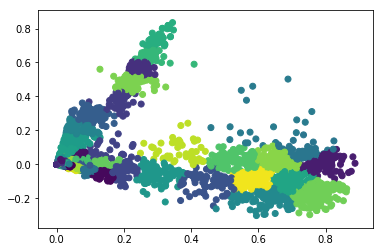

adj rand index: 0.03379115412538776


In [46]:
mbkmeans = MiniBatchKMeans(init='random', n_clusters=52, batch_size=100).fit(X_train_svd)
predict_mini = mbkmeans.predict(X_train_svd)

plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=predict_mini)
plt.show()

print('adj rand index: {}'.format(adjusted_rand_score(y_train, predict_mini)))

### Mean-shift

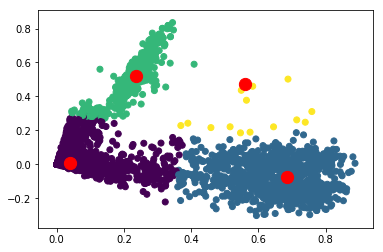

number of estimated clusters: 4
adj rand index: -0.011389018882714711


In [50]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X_train_svd, quantile=0.3)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X_train_svd)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters_ = len(np.unique(labels))

plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=labels)
plt.scatter(cluster_centers[:,0], cluster_centers[:,1], c='r', s=150)
plt.show()

print('number of estimated clusters: {}'.format(n_clusters_))
print('adj rand index: {}'.format(adjusted_rand_score(y_train, labels)))

### Spectral Clustering

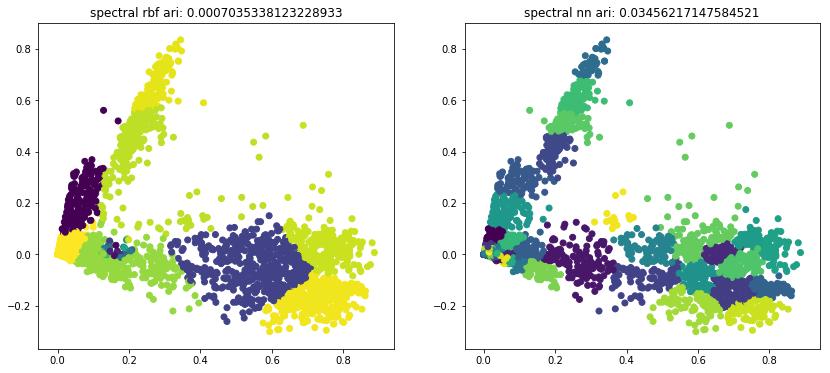

In [51]:
from sklearn.cluster import SpectralClustering

sc_rbf = SpectralClustering(n_clusters=52, affinity='rbf').fit(X_train_svd)
sc_nn = SpectralClustering(n_clusters=52, affinity='nearest_neighbors').fit(X_train_svd)

predict_rbf = sc_rbf.fit_predict(X_train_svd)
predict_nn = sc_nn.fit_predict(X_train_svd)

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_rbf)
plt.title('spectral rbf ari: {}'.format(adjusted_rand_score(y_train, predict_rbf)))

plt.subplot(122)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_nn)
plt.title('spectral nn ari: {}'.format(adjusted_rand_score(y_train, predict_nn)))
plt.show()

### Affinity propagation

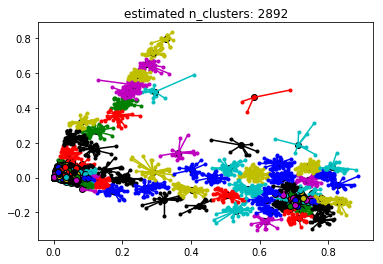

adjusted rand index: 0.014126273125243118


In [54]:
from sklearn.cluster import AffinityPropagation
from itertools import cycle

af = AffinityPropagation().fit(X_train_svd)
af_pred = af.fit_predict(X_train_svd)

cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train_svd[cluster_centers_indices[k]]
    plt.plot(
        X_train_svd[class_members, 0],
        X_train_svd[class_members, 1],
        col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train_svd[class_members]:
        plt.plot([cluster_center[0], x[0]],
                 [cluster_center[1], x[1]],
                 col)

plt.title('estimated n_clusters: {}'.format(n_clusters_))
plt.show()

print('adjusted rand index: {}'.format(adjusted_rand_score(y_train, af_pred)))

## Tokenization with Spacy

In [ ]:
nlp = spacy.load('en')
X_train_

In [ ]:
#conform with spacys character limit
train_substrings = [train[i:i+999999] for i in range(0, len(train), 999999)]
test_substrings = [test[i:i+999999] for i in range(0, len(test), 999999)]

In [ ]:
train0 = train_substrings[0]
train1 = train_substrings[1]
train2 = train_substrings[2]
train3 = train_substrings[3]
train4 = train_substrings[4]
train5 = train_substrings[5]
train6 = train_substrings[6]

test0 = test_substrings[0]
test1 = test_substrings[1]
test2 = test_substrings[2]

In [ ]:
nlp = spacy.load('en')

start = time.clock()
train0_doc = nlp(train0)
print(time.clock() - start)
train1_doc = nlp(train1)
print(time.clock() - start)
train2_doc = nlp(train2)
print(time.clock() - start)
train3_doc = nlp(train3)
print(time.clock() - start)
train4_doc = nlp(train4)
print(time.clock() - start)
train5_doc = nlp(train5)
print(time.clock() - start)
train6_doc = nlp(train6)
print(time.clock() - start)
test0_doc = nlp(test0)
print(time.clock() - start)
test1_doc = nlp(test1)
print(time.clock() - start)
test2_doc = nlp(test2)
print(time.clock() - start)

In [ ]:
train_docs = [train0_doc, train1_doc, train2_doc, train3_doc, train4_doc, train5_doc, train6_doc]
train_tokens = []
for doc in train_docs:
    for token in doc:
        train_tokens.append(token)
        
test_docs = [test0_doc, test1_doc, test2_doc]
test_tokens = []
for doc in test_docs:
    for token in doc:
        test_tokens.append(token)

In [ ]:
#make sure this worked
print(len(train_tokens))
print(len(train0_doc) + len(train1_doc) + len(train2_doc) + len(train3_doc)
      + len(train4_doc) + len(train5_doc) + len(train6_doc))

print(len(test_tokens))
print(len(test0_doc) + len(test1_doc) + len(test2_doc))